In [1]:
%matplotlib inline
import sys
sys.path.insert(0, 'src')

In [2]:
# import stlcg
import stlcg_agm as stlcg
import stlviz as viz
from stlcg import Expression
from utils import print_learning_progress

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import importlib

In [4]:
t = t = np.arange(-3, 3, 0.2, dtype=np.float32)
x_np = 0.5 * np.exp(-t**2).reshape([1, t.shape[0], 1])
w_np = (0.4*np.exp(-(t + 0.5)**2) + 0.2*np.exp(-(t - 3)**2)).reshape([1, t.shape[0], 1])

x = torch.tensor(x_np, requires_grad=False)
w = torch.tensor(w_np, requires_grad=False)
c = torch.tensor(1.0, dtype=torch.float, requires_grad=True)
d = torch.tensor(0.9, dtype=torch.float, requires_grad=True)

In [5]:
h = torch.tensor([1, 2, 3, 4, 5]).float().unsqueeze(0).unsqueeze(0).requires_grad_(True)
xx = torch.tensor([1.1, 0.9, 0.95, 0.6, 1.0]).float().unsqueeze(0).unsqueeze(-1)
xx = torch.cat([xx,-xx], dim=-1).requires_grad_(True)
c = torch.ones_like(h)

In [6]:
m = stlcg.Minish()
alw = stlcg.Always(subformula=stlcg.Identity())

In [7]:
xx

tensor([[[ 1.1000, -1.1000],
         [ 0.9000, -0.9000],
         [ 0.9500, -0.9500],
         [ 0.6000, -0.6000],
         [ 1.0000, -1.0000]]], requires_grad=True)

In [8]:
alw(xx)

tensor([[[ 1.1000, -1.1000],
         [ 0.9000, -1.1000],
         [ 0.9000, -1.1000],
         [ 0.6000, -1.1000],
         [ 0.6000, -1.1000]]], grad_fn=<CatBackward>)

In [9]:
m.distributed_true_min(xx)

tensor([[[ 0.6000, -1.1000]]], grad_fn=<AddBackward0>)

In [30]:
def distributed_true_max(x, dim=1, keepdim=True):
    c = 0.0
    xs = torch.split(x, 1, dim=1)                              # time_dim tuple
    h = xs[0]
    time_dim = len(xs)
    for i in range(time_dim):
        h = (x == h) * ((h * c + x)/ (c + 1)) + (x < h) * (x) + (x > h) * (h)
        c = (x == h) * (c + 1.0) + (x < h) * (1.0) + (x > h) * (c)
    return h

In [34]:
c = 0.0
xs = torch.split(xx, 1, dim=1)                              # time_dim tuple
h = xs[0]
time_dim = len(xs)
for x in xs:
    x = xs[i]
    h = (x == h) * ((h * c + x)/ (c + 1)) + (x < h) * (x) + (x > h) * (h)
    c = (x == h) * (c + 1.0) + (x < h) * (1.0) + (x > h) * (c)
    print(h)

tensor([[[ 1.0000, -1.1000]]], grad_fn=<AddBackward0>)
tensor([[[ 1.0000, -1.1000]]], grad_fn=<AddBackward0>)
tensor([[[ 1.0000, -1.1000]]], grad_fn=<AddBackward0>)
tensor([[[ 1.0000, -1.1000]]], grad_fn=<AddBackward0>)
tensor([[[ 1.0000, -1.1000]]], grad_fn=<AddBackward0>)


In [32]:
h

tensor([[[ 0.6000, -1.1000]]], grad_fn=<AddBackward0>)

In [10]:
scale=-1
alw._run_rnn_cell(xx, scale)

([tensor([[[1.1000, 1.1000]]], grad_fn=<AddBackward0>),
  tensor([[[0.9000, 0.9000]]], grad_fn=<AddBackward0>),
  tensor([[[0.9000, 0.9000]]], grad_fn=<AddBackward0>),
  tensor([[[0.6000, 0.6000]]], grad_fn=<AddBackward0>)],
 [(tensor([[[1.1000, 1.1000]]], grad_fn=<AddBackward0>), tensor([[[1., 1.]]])),
  (tensor([[[0.9000, 0.9000]]], grad_fn=<AddBackward0>), tensor([[[1., 1.]]])),
  (tensor([[[0.9000, 0.9000]]], grad_fn=<AddBackward0>), tensor([[[1., 1.]]])),
  (tensor([[[0.6000, 0.6000]]], grad_fn=<AddBackward0>),
   tensor([[[1., 1.]]]))])

In [108]:
xx.shape

torch.Size([1, 4, 2])

In [109]:
torch.split(xx, 1, dim=1)

(tensor([[[1., 1.]]], grad_fn=<SplitBackward>),
 tensor([[[0.9000, 0.9000]]], grad_fn=<SplitBackward>),
 tensor([[[0.9500, 0.9500]]], grad_fn=<SplitBackward>),
 tensor([[[1., 1.]]], grad_fn=<SplitBackward>))

In [104]:
scale = 1000
r = m(xx, scale, dim=1)

In [105]:
r.backward()
with torch.no_grad():
    print(xx.grad)
xx.grad.zero_()

tensor([[[ 5.0000e-01],
         [-1.3817e-42],
         [-4.7254e-21],
         [ 5.0000e-01]]])


tensor([[[0.],
         [0.],
         [0.],
         [0.]]])

# Signal convolutional logic

In [5]:
ϕa = stlcg.Integral1d(subformula=stlcg.Identity(), padding_type="zero")
ϕb = stlcg.Integral1d(subformula=stlcg.Identity(), interval=[0, 5], padding_type="zero")
ϕc = stlcg.Integral1d(subformula=stlcg.Identity(), interval=[2, 5], padding_type="zero")
ϕd = stlcg.Always(subformula=stlcg.Identity(), interval=[0, 5])
ϕe = stlcg.Always(subformula=stlcg.Identity(), interval=[2, 5])

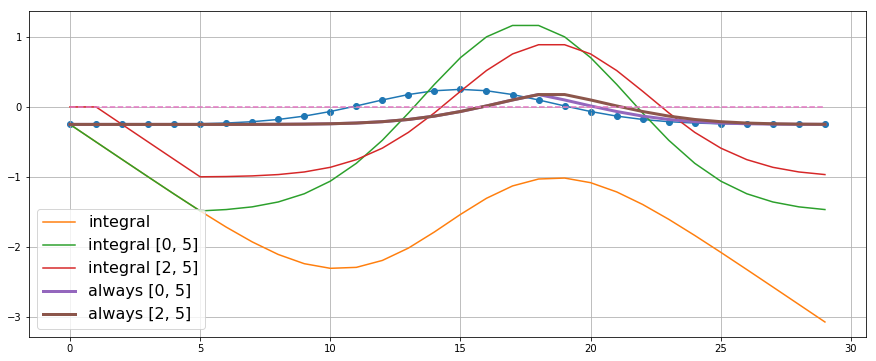

In [6]:
dt = 1.0
signal = x - 0.25
bsignal = 1.0*(signal > 0)
mask = torch.ones(signal.shape)
mask *= 2
mask[:,0,:] -= 1
mask[:,-1,:] -= 1
mask *= dt/2
p = 5
plt.figure(figsize=(15,6))

plt.plot(range(len(signal.squeeze())), signal.squeeze().numpy())
plt.scatter(range(len(signal.squeeze())), signal.squeeze().numpy())

plt.plot(range(len(signal.squeeze())), ϕa(signal).squeeze().numpy(), label="integral")
plt.plot(range(len(signal.squeeze())), ϕb(signal).squeeze().numpy(), label="integral [0, 5]")
plt.plot(range(len(signal.squeeze())), ϕc(signal).squeeze().numpy(), label="integral [2, 5]")
plt.plot(range(len(signal.squeeze())), ϕd(signal).squeeze().numpy(), linewidth=3, label="always [0, 5]")
plt.plot(range(len(signal.squeeze())), ϕe(signal).squeeze().numpy(), linewidth=3, label="always [2, 5]")

plt.plot([0, len(signal.squeeze())-1], [0, 0], "--")
plt.legend(fontsize=16)
plt.grid()

In [7]:
obs_1 = torch.tensor([-0.5, 0.5, 0.5, 0.75]).float()     # red box in bottom right corner
def inside_box(xy, obs):
    x = stlcg.Expression('x', xy[:,:1].unsqueeze(0))
    y = stlcg.Expression('y', xy[:,1:].unsqueeze(0))
    r1 = stlcg.Expression(obs[:1].unsqueeze(-1).unsqueeze(-1))
    r2 = stlcg.Expression(obs[1:2].unsqueeze(-1).unsqueeze(-1))
    r3 = stlcg.Expression(obs[2:3].unsqueeze(-1).unsqueeze(-1))
    r4 = stlcg.Expression(obs[3:4].unsqueeze(-1).unsqueeze(-1))
    inputs = ((x,x), (y,y))
    return ((x > r1) & (x < r2)) & ((y > r3) & (y < r4)), inputs
def control_limit(u, u_max):
    u_abs = stlcg.Expression('u', u.norm(dim=1, keepdim=True).unsqueeze(0))
    um = stlcg.Expression(u_max.unsqueeze(-1).unsqueeze(-1))
    return stlcg.Always(subformula=(u_abs < um)), u_abs

In [8]:
dx = 0.06
n = np.stack([np.arange(-1, 1, dx), np.arange(-1, 1, dx)]).T
x0 = np.array([-1.0, 1.0])
xf = np.ones(2)
N = n.shape

u_max = torch.as_tensor(0.9).float()       # u max


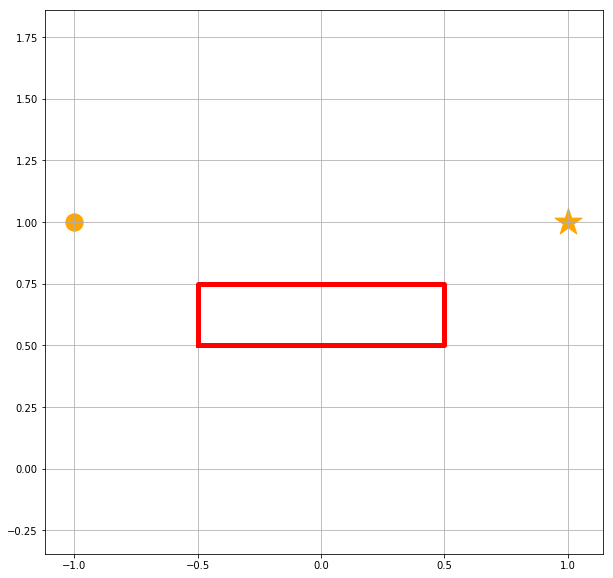

In [9]:
plt.figure(figsize=(10,10))
plt.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
plt.scatter(*x0, s=300, c="orange")
plt.scatter(*xf, s=800, marker='*', c="orange")
plt.axis("equal")
plt.grid()


In [10]:
Δt = 0.1
A = np.eye(2)
B = np.eye(2) * Δt
E = np.zeros([2*(N[0]+1), (2*N[0] - 1)*N[1]])
d = np.zeros((2*(N[0]+1)))

for i in range(N[0]-1):
    E[2*i:2*i+2,2*i:2*i+2] = A
    E[2*i:2*i+2,2*(i+1):2*(i+1)+2] = -A
    j = 2*i + N[0]*N[1]
    E[2*i:2*i+2,j:j+2] = B
E[2*(N[0]-1):2*(N[0]-1)+2, :2] = A
E[2*N[0]:2*N[0]+2, 2*(N[0]-1):2*(N[0]-1)+2] = A

d[-4:-2] = x0
d[-2:] = xf

Q = np.zeros([(2*N[0] - 1)*N[1], (2*N[0] - 1)*N[1]])           # no state cost
R = np.eye((N[0]-1) * N[1])                                    # control cost
Q[N[1]*N[0]:, N[1]*N[0]:] = R
c = np.zeros([(2*N[0] - 1)*N[1]])

# building up the KKT matrix
K = np.zeros([Q.shape[0]+E.shape[0], Q.shape[1] + E.shape[0]])
K[:Q.shape[0], :] = np.concatenate([Q, E.T], axis=1)
K[Q.shape[0]:, :E.shape[1]] = E
D = np.concatenate([-c, d])

KK = torch.as_tensor(K).float()
DD = torch.as_tensor(D).float()

# matrix describing the dynamics and state constraints
CC = torch.as_tensor(d).float()
EE = torch.as_tensor(E).float()

# solving the KKT matrix (i.e., straight line) and getting only the states (not the lagrange multipliers)
Z = torch.as_tensor((np.linalg.inv(K) @ D)[:(2*N[0] - 1) * N[1]]).float().requires_grad_(True)


In [11]:
Z = torch.as_tensor((np.linalg.inv(K) @ D)[:(2*N[0] - 1) * N[1]]).float().requires_grad_(True)

In [12]:
X = Z[:N[0]*N[1]].reshape(N[0], N[1])
x = X[:,:1].unsqueeze(0)
y = X[:,1:].unsqueeze(0)

U = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1])].reshape(N[0]-1,N[1])
ux = U[:,:1]
uy = U[:,1:]

T = 10
inside_box_1, _ = inside_box(X, obs_1)
ϕ1 = stlcg.Eventually(subformula=stlcg.Integral1d(subformula=inside_box_1, interval=[0,T], padding_type="same", custom_number=0.1))
ϕ2 = stlcg.Eventually(subformula=stlcg.Always(subformula=inside_box_1, interval=[0,T]))

θ, _ = control_limit(U, u_max)

box_inputs = ((x, x),(y, y))
control_inputs = U.norm(dim=1, keepdim=True).unsqueeze(0)



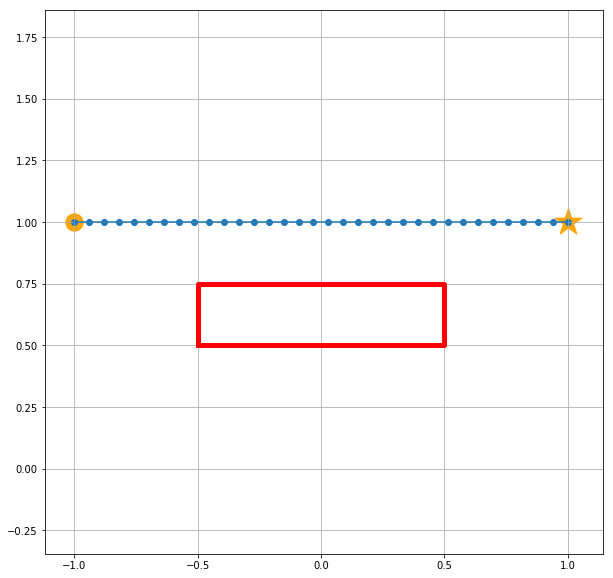

In [13]:
plt.figure(figsize=(10,10))
plt.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
plt.scatter(*x0, s=300, c="orange")
plt.scatter(*xf, s=800, marker='*', c="orange")
plt.plot(x.detach().squeeze().numpy(), y.detach().squeeze().numpy())
plt.scatter(x.detach().squeeze().numpy(), y.detach().squeeze().numpy())
plt.axis("equal")
plt.grid()


In [14]:
scale = -1
agm = False

robustness_1 = torch.relu(-ϕ1.robustness(box_inputs, scale=scale).squeeze())
robustness_2 = torch.relu(-θ.robustness(control_inputs, scale=scale).squeeze())

plt.figure(figsize=(16, 8))
signal = inside_box_1(box_inputs, scale=scale, agm=agm).detach().squeeze().numpy()
plt.plot(range(len(signal)), signal, label="inside box")
plt.scatter(range(len(signal)), signal, s=50)

integral = ϕ1.subformula(box_inputs, scale=scale, agm=agm).detach().squeeze().numpy()
plt.plot(range(len(signal)), integral, label="integral [0, 5] inside box")
plt.scatter(range(len(signal)), integral)

rob = ϕ1(box_inputs, scale=scale, agm=agm).detach().squeeze().numpy()
plt.plot(range(len(signal)), rob, label="eventually integral [0, 5] inside box")
plt.scatter(range(len(signal)), rob)

always = ϕ2.subformula(box_inputs, scale=scale, agm=agm).detach().squeeze().numpy()
plt.plot(range(len(signal)), always, label="always [0, 5] inside box")
plt.scatter(range(len(signal)), always, s=100)

rob = ϕ2(box_inputs, scale=scale, agm=agm).detach().squeeze().numpy()
plt.plot(range(len(signal)), rob, label="eventually always [0, 5] inside box")
plt.scatter(range(len(signal)), rob, s=25)

plt.legend(fontsize=16)
plt.grid()
plt.ylim([-2.8, -2.7])


ValueError: not enough values to unpack (expected 2, got 1)

In [332]:
s.detach().numpy()

array([[[-5.5      ],
        [-5.439394 ],
        [-5.318182 ],
        [-5.136364 ],
        [-4.89394  ],
        [-4.64394  ],
        [-4.3939395],
        [-4.1439395],
        [-3.8939395],
        [-3.6439395],
        [-3.3939393],
        [-3.1439395],
        [-2.9545455],
        [-2.8257575],
        [-2.7575758],
        [-2.75     ],
        [-2.75     ],
        [-2.75     ],
        [-2.75     ],
        [-2.75     ],
        [-2.75     ],
        [-2.75     ],
        [-2.75     ],
        [-2.75     ],
        [-2.75     ],
        [-2.75     ],
        [-2.75     ],
        [-2.75     ],
        [-2.75     ],
        [-2.7575758],
        [-2.8257575],
        [-2.9545455],
        [-3.1439395],
        [-3.3939395]]], dtype=float32)

In [358]:
scale = 50
s = torch.tensor(ϕ1.subformula(box_inputs, scale=scale, agm=agm).detach().numpy()).requires_grad_(True)
r = m(s, scale)

In [1]:
s

NameError: name 's' is not defined

In [359]:
r.backward()
with torch.no_grad():
    print(torch.cat([s.grad, s], dim=-1))
# r.grad.zero_()

tensor([[[ 0.0000e+00, -5.5000e+00],
         [ 0.0000e+00, -5.4394e+00],
         [ 0.0000e+00, -5.3180e+00],
         [ 0.0000e+00, -5.1340e+00],
         [ 0.0000e+00, -4.8885e+00],
         [-6.6272e-41, -4.6350e+00],
         [-1.5687e-35, -4.3846e+00],
         [-3.5626e-30, -4.1345e+00],
         [-7.8091e-25, -3.8845e+00],
         [-1.6255e-19, -3.6345e+00],
         [-3.1008e-14, -3.3845e+00],
         [-4.9370e-09, -3.1345e+00],
         [-3.0750e-05, -2.9452e+00],
         [-5.0889e-03, -2.8166e+00],
         [ 5.6361e-02, -2.7506e+00],
         [ 8.7149e-02, -2.7461e+00],
         [ 6.2359e-02, -2.7496e+00],
         [ 5.9997e-02, -2.7500e+00],
         [ 5.9822e-02, -2.7500e+00],
         [ 5.9811e-02, -2.7500e+00],
         [ 5.9811e-02, -2.7500e+00],
         [ 5.9811e-02, -2.7500e+00],
         [ 5.9811e-02, -2.7500e+00],
         [ 5.9811e-02, -2.7500e+00],
         [ 5.9811e-02, -2.7500e+00],
         [ 5.9822e-02, -2.7500e+00],
         [ 5.9995e-02, -2.7500e+00],
 

In [315]:
robustness_1.backward()
with torch.no_grad():
    print(Z.grad[:N[0]*N[1]].reshape(N[0], N[1]))
# r.grad.zero_()

tensor([[-1.0872e-28, -3.6239e-38],
        [ 3.2620e-19,  3.4835e-26],
        [-3.0545e-12, -9.2580e-17],
        [ 1.0141e-07,  6.3973e-10],
        [-1.3339e-05,  2.4384e-06],
        [ 1.3375e-06,  6.4493e-05],
        [ 1.8259e-08,  1.5177e-04],
        [ 1.4627e-10,  3.2880e-04],
        [ 9.7025e-13,  6.8286e-04],
        [ 5.8537e-15,  1.3910e-03],
        [ 3.3413e-17,  2.8072e-03],
        [ 1.8403e-19,  5.6397e-03],
        [ 9.8888e-22,  1.1305e-02],
        [ 5.2184e-24,  2.2635e-02],
        [ 2.7160e-26,  4.5297e-02],
        [ 1.3979e-28,  9.0602e-02],
        [ 7.1136e-31,  1.8120e-01],
        [-1.4229e-30,  3.6245e-01],
        [-1.1488e-27,  7.4452e-01],
        [-6.0217e-25,  1.0043e+00],
        [-2.3023e-22,  9.9863e-01],
        [-8.7230e-20,  9.9721e-01],
        [-3.2448e-17,  9.9438e-01],
        [-1.1768e-14,  9.8872e-01],
        [-4.1132e-12,  9.7739e-01],
        [-1.3565e-09,  9.5473e-01],
        [-4.0457e-07,  9.0940e-01],
        [-9.8513e-05,  8.188

In [306]:
m = stlcg.Maxish()
s = torch.tensor([1, 1, 1, 0.5, 1, 1]).float().requires_grad_(True)
scale = 50
r = m(s, scale, dim=0)
r

tensor([1.], grad_fn=<SumBackward1>)

In [307]:
r.backward()
with torch.no_grad():
    print(s.grad)
# r.grad.zero_()

tensor([ 2.0000e-01,  2.0000e-01,  2.0000e-01, -6.6662e-11,  2.0000e-01,
         2.0000e-01])


In [ ]:
r

0: loss: -0.003   robustness_1: 0.000     robustness_2: -0.272     cont: 0.000097
100: loss: -0.003   robustness_1: 0.000     robustness_2: -0.272     cont: 0.000107
200: loss: -0.003   robustness_1: 0.000     robustness_2: -0.272     cont: 0.000096
300: loss: -0.003   robustness_1: 0.000     robustness_2: -0.272     cont: 0.000091
400: loss: -0.003   robustness_1: 0.000     robustness_2: -0.272     cont: 0.000098
500: loss: -0.003   robustness_1: 0.000     robustness_2: -0.272     cont: 0.000091
600: loss: -0.003   robustness_1: 0.000     robustness_2: -0.272     cont: 0.000087
700: loss: -0.003   robustness_1: 0.000     robustness_2: -0.272     cont: 0.000095
800: loss: -0.003   robustness_1: 0.000     robustness_2: -0.272     cont: 0.000088


KeyboardInterrupt: 

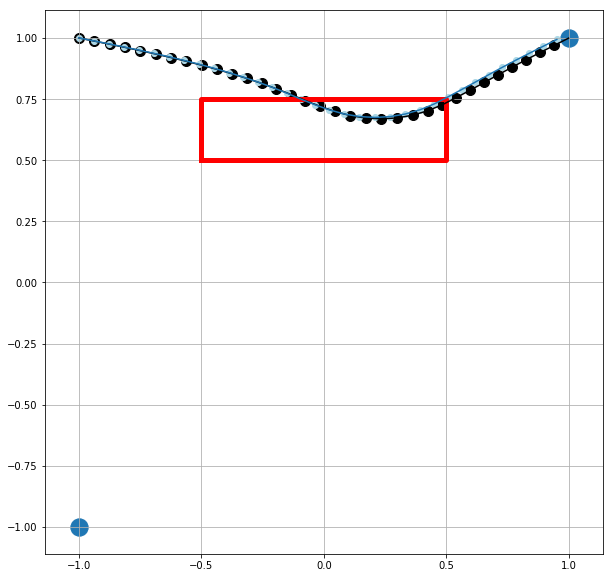

In [308]:
##### hyperparameters #####
γ = 0.1
lr = 0.05
margin = .5 # can add a margin so things are not right on the boundary
keepdim = True
scale = 100
agm = False
use_relu = False
###########################
fig_path = "experiments/integral/figs"
for _ in range(5000):
#     optimizer.zero_grad()
#     scale = 1.0 + _/5000 * 50
    X = Z[:N[0]*N[1]].reshape(N[0], N[1])
    U = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1])].reshape(N[0]-1,N[1])
    ux = U[:,:1]
    uy = U[:,1:]
    
    box_inputs = ((x, x),(y, y)) # changes as Z changes (points to the Z tensor)
    control_inputs = U.norm(dim=1, keepdim=True).unsqueeze(0)
    
    robustness_1 = torch.relu(-(ϕ1.robustness(box_inputs, scale=scale, keepdim=keepdim, agm=agm, use_relu=use_relu).squeeze() - margin) )
#     robustness_1 = torch.relu(-(ϕ2.robustness(box_inputs, scale=scale, keepdim=keepdim, agm=agm).squeeze() - margin) )

    robustness_2 = -θ.robustness(control_inputs, scale=-1, keepdim=keepdim).squeeze()

    robustness = robustness_1 + γ*robustness_2

    cont = (torch.matmul(EE, Z) - CC).pow(2).sum()
    
    loss = cont + γ*robustness 
    loss.backward()
    with torch.no_grad():
        Z -= lr* Z.grad
    
    if _ % 100 == 0:
        xy = Z[:N[0]*N[1]].reshape(N[0],N[1])
        u = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1]) ].reshape(N[0]-1,N[1])
        # plt.scatter(past.detach().numpy()[:,0], past.detach().numpy()[:,1])
        plt.figure(figsize=(10,10))
        plt.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
        plt.plot(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black")
        plt.scatter(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black", s=100)
        plt.scatter([-1,1], [-1,1], s=300)
        plt.axis("equal")


        xs = [x0]
        us = u.detach().numpy()
        for i in range(33):
            x_next = A @ xs[i] + B @ us[i]
            xs.append(x_next)
        xs = np.stack(xs)
        plt.plot(xs[:,0], xs[:,1])
        plt.scatter(xs[:,0], xs[:,1], c="lightblue")
        plt.grid()
        plt.savefig(fig_path + "/" + str(_).rjust(4, '0') + ".png")
        print("%i: loss: %.3f   robustness_1: %.3f     robustness_2: %.3f     cont: %.6f"%(_, loss.detach().numpy(), robustness_1.detach().numpy(),  robustness_2.detach().numpy(), cont.detach().numpy()))
        plt.close()
#     if (robustness < 1E-2) & (cont < 1E-6):
#         print("FINISHED!")
#         break
    Z.grad.zero_()

In [177]:
data_path = "experiments/integral"

np.save(data_path + "/X_integral.npy", X.detach().numpy())
np.save(data_path + "/U_integral.npy", U.detach().numpy())

In [185]:
data_path = "experiments/integral"

np.save(data_path + "/X_always.npy", X.detach().numpy())
np.save(data_path + "/U_always.npy", U.detach().numpy())

In [186]:
x_integral = np.load(data_path + "/X_integral.npy")
x_always = np.load(data_path + "/X_always.npy")

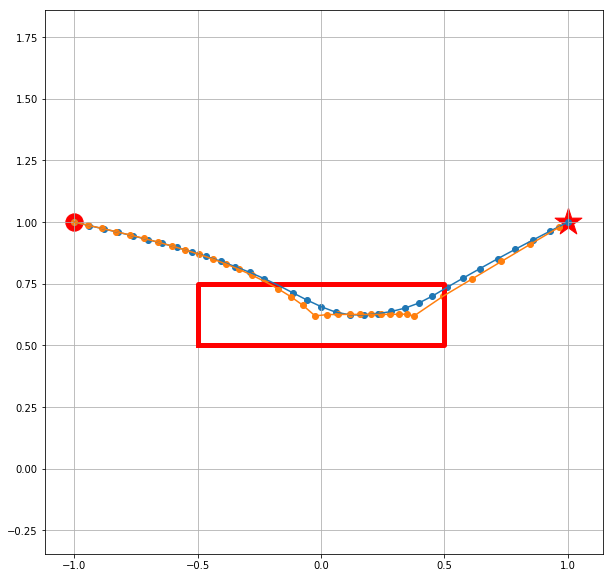

In [189]:
plt.figure(figsize=(10,10))
plt.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
plt.scatter(*x0, s=300, c="red")
plt.scatter(*xf, s=800, marker='*', c="red")

x = x_integral[:,0]
y = x_integral[:,1]
plt.plot(x, y)
plt.scatter(x, y)

x = x_always[:,0]
y = x_always[:,1]
plt.plot(x, y)
plt.scatter(x, y)

plt.axis("equal")
plt.grid()


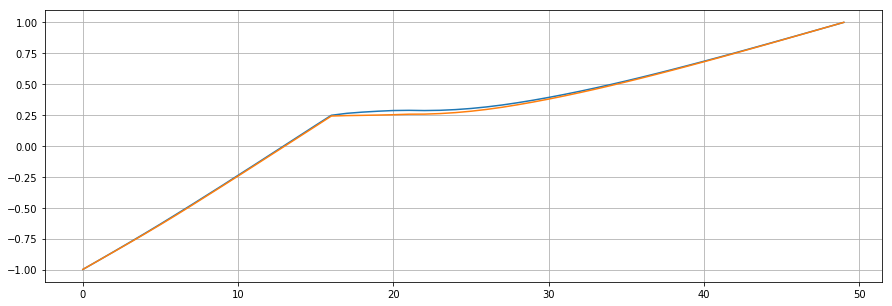

In [73]:
plt.figure(figsize=(15,5))

x = x_integral[:,0]
y = x_integral[:,1]
plt.plot(x)
# plt.scatter(x, y)

x = x_always[:,0]
y = x_always[:,1]
plt.plot(x)
# plt.scatter(x, y)
plt.grid()

In [191]:
m = stlcg.Maxish()

In [217]:
x = torch.tensor([1.0, 1.0, 0.5]).requires_grad_(True)

In [218]:
m(x, scale=1, dim=0)

tensor([0.8837], grad_fn=<SumBackward1>)

In [219]:
y = m(x, scale=-1, dim=0)

In [220]:
y.backward()
with torch.no_grad():
    print(x.grad)


tensor([0., 1., 0.])


In [246]:
x

tensor([[[6.1705e-05],
         [1.9683e-04],
         [5.7962e-04],
         [1.5756e-03],
         [3.9535e-03],
         [9.1578e-03],
         [1.9582e-02],
         [3.8652e-02],
         [7.0429e-02],
         [1.1846e-01],
         [1.8394e-01],
         [2.6365e-01],
         [3.4884e-01],
         [4.2607e-01],
         [4.8039e-01],
         [5.0000e-01],
         [4.8039e-01],
         [4.2607e-01],
         [3.4884e-01],
         [2.6365e-01],
         [1.8394e-01],
         [1.1846e-01],
         [7.0429e-02],
         [3.8652e-02],
         [1.9582e-02],
         [9.1578e-03],
         [3.9535e-03],
         [1.5755e-03],
         [5.7961e-04],
         [1.9683e-04]]])

In [231]:
rnn_dim = 5

In [306]:
xx = torch.cat([x, x], dim=-1)

In [316]:
h0 = xx[:,:5,:]*100
z = xx[:,:1,:]
h0, z

(tensor([[[0.0062, 0.0062],
          [0.0197, 0.0197],
          [0.0580, 0.0580],
          [0.1576, 0.1576],
          [0.3954, 0.3954]]]), tensor([[[6.1705e-05, 6.1705e-05]]]))

In [317]:
M = torch.tensor(np.diag(np.ones(rnn_dim-1), k=1)).requires_grad_(False).float()
b = torch.zeros(rnn_dim).unsqueeze(-1)
b[-1] = 1.0

In [318]:
M

tensor([[0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.]])

In [319]:
torch.matmul(M , h0).shape

torch.Size([1, 5, 2])

In [320]:
(b * z).shape

torch.Size([1, 5, 2])

In [322]:
(torch.matmul(M , h0) + b * z).shape

torch.Size([1, 5, 2])